# Stocks Prediction Project
Goal: Predict the percent change between open and close.<br>
#### Author: Miguel Martinez

### Import all necessary libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV

### Set global variables
These variables are used when creating time-series data.<br>
For example: "smaShort = 15" means create a moving average from the last 15 days.<br>
"previousDays = 15" means calculate day to day percent changes for the last 15 days<br>

In [2]:
# Global Variables
smaShort = 15
smaMedium = 85
smaLong = 200
previousDays = 15

### Read data from H5 File
Hierarchical Data Format has several advantages over CSV:<br>
Read/Write Faster<br>
Can be accessed like a dictionary<br>
Can modify only the key/value needed

In [3]:
# Read in symbols
symbols = pd.read_hdf('data/data.h5', 'symbols')
print(symbols)

   symbols
0     ACGL
1     ABCO
2     ACAD
3     ACHC
4     AAXJ
5     ABMD
6     AAPL
7     ABTL
8     AAME
9     ABUS
10     ABY
11    AAWW
12     AAL
13    ABIO
14    ABIL
15    ACFC
16    ABAX
17    AAOI
18    ACAS
19    ACHN
20    ACET
21    ABCB
22    ABCW
23    AAON
24    ABCD
25    ACIW
26    ABDC
27    ACAT
28    ABEO
29    ABAC


In [4]:
# Read in the actual trading data
dataDictionary = {}

for index, row in symbols.iterrows():
    dataDictionary[row['symbols']] = pd.read_hdf('data/data.h5', row['symbols'])
    #print(row['symbols'])

# Print out 5 days from the first symbol
print(list(dataDictionary.values())[0].head())

  symbol marketCap  ipoYear       sector               industry        date  \
0   ABUS  $325.43M       -1  Health Care  Major Pharmaceuticals  2016-11-11   
1   ABUS  $325.43M       -1  Health Care  Major Pharmaceuticals  2016-11-10   
2   ABUS  $325.43M       -1  Health Care  Major Pharmaceuticals  2016-11-09   
3   ABUS  $325.43M       -1  Health Care  Major Pharmaceuticals  2016-11-08   
4   ABUS  $325.43M       -1  Health Care  Major Pharmaceuticals  2016-11-07   

   open  high   low  close  volume  adjclose  
0  2.75  2.85  2.65   2.80  271400      2.80  
1  2.85  2.89  2.66   2.75  173100      2.75  
2  2.90  3.15  2.75   2.80  235300      2.80  
3  2.95  3.05  2.80   2.90  111300      2.90  
4  3.00  3.10  2.90   2.95   74600      2.95  


### Feature Engineering
This function takes the raw stock trading data, converts it to a time-series, and adds the following features:<br>
Close-Open Percent Change<br>
Low-High Percent<br>
Day to Day Percent Changes for: Open, High, Low, Close<br>
Short Simple Moving Average<br>
Medium Simple Moving Average<br>
Long Simple Moving Average<br>
SMA short over SMA Medium (boolean)<br>
SMA Medium over SMA Long (boolean)<br>
SMA Short over SMA Long (boolean)


In [5]:
def preprocessingAll( dict , features):
    # each key is a symbol
    # each value is a dataframe
    for k in dict.keys():
        days_df = dict[k]
        
        # step 1 - reorder to have oldest date on top
        days_df = days_df.sort_values('date', ascending=True)
        
        #Create intraday Percent Changes
        days_df['co_pct_change'] = (days_df['close'] / days_df['open'] - 1) 
        days_df['lh_pct_change'] = (days_df['low'] / days_df['high'] - 1)
        
        metricsToGoBack = ['open', 'high', 'low', 'close']
          
        #add previous days
        for x in range(previousDays):
            currCount = x + 1
            
            # compute regular metrics
            for metric in metricsToGoBack:
                featureName = metric + '_pct_change_previous_' + str(currCount)
                days_df[featureName] = days_df[metric].pct_change()
                days_df[featureName] = days_df[featureName].shift(currCount)
                features.append(featureName)
                
            #add columns
            feature = 'co_pct_change_ previous_' + str(currCount)
            days_df[feature] = days_df['co_pct_change']
            days_df[feature] = days_df[feature].shift(currCount)
            features.append(feature)
            
            feature2 = 'weekday_previous_' + str(currCount)
            days_df[feature2] = days_df['date'].apply(lambda y: (y.weekday()))
            days_df[feature2] = days_df[feature2].shift(currCount)
            features.append(feature2)
            
            feature3 = 'dayofyear_previous_' + str(currCount)
            days_df[feature3] = days_df['date'].apply(lambda y: (y.timetuple()[7]))
            days_df[feature3] = days_df[feature3].shift(currCount)
            features.append(feature3)
        
            #rolling short
            smaShortFeat = 'sma_short_' + str(smaShort) + '_prev_' + str(currCount)
            days_df[smaShortFeat] = days_df['close'].rolling(smaShort).mean()
            days_df[smaShortFeat] = days_df[smaShortFeat].shift(currCount)
            features.append(smaShortFeat)
            
            #rolling medium
            smaMediumFeat = 'sma_medium_' + str(smaMedium) + '_prev_' + str(currCount)
            days_df[smaMediumFeat] = days_df['close'].rolling(smaMedium).mean()
            days_df[smaMediumFeat] = days_df[smaMediumFeat].shift(currCount)
            features.append(smaMediumFeat)
            
            #rolling long
            smaLongFeat = 'sma_long_' + str(smaLong) + '_prev_' + str(currCount)
            days_df[smaLongFeat] = days_df['close'].rolling(smaLong).mean()
            days_df[smaLongFeat] = days_df[smaLongFeat].shift(currCount)
            features.append(smaLongFeat)
            
            #SMA short over SMA Medium
            smaShortFeatOverMed = 'sma_short_over_medium_prev_' + str(currCount)
            days_df[smaShortFeatOverMed] = days_df.apply(lambda x: 1 if x[smaShortFeat] > x[smaMediumFeat] else 0, axis=1)
            features.append(smaShortFeatOverMed)
            
            #SMA Medium over SMA Long
            smaMedFeatOverLong = 'sma_med_over_long_prev_' + str(currCount)
            days_df[smaMedFeatOverLong] = days_df.apply(lambda x: 1 if x[smaMediumFeat] > x[smaLongFeat] else 0, axis=1)
            features.append(smaMedFeatOverLong)
            
            #SMA Short over SMA Long
            smaShortFeatOverLong = 'sma_short_over_long_prev_' + str(currCount)
            days_df[smaShortFeatOverLong] = days_df.apply(lambda x: 1 if x[smaShortFeat] > x[smaLongFeat] else 0, axis=1)
            features.append(smaShortFeatOverLong)
        
        #remove rows with NaNs after pct changes and moving averages
        daysToCut = previousDays + smaLong - 1
        days_df.drop(days_df.index[:daysToCut], inplace=True)
        days_df['daysToCut'] = daysToCut
        
        # remove duplicate features
        features = sorted(list(set(features)))
        
        #scale
        for feat in features:
            currentDF = pd.DataFrame(days_df[feat])
            currentDF = pd.DataFrame(preprocessing.scale(currentDF), index = currentDF.index, columns = currentDF.columns)
            days_df[feat] = currentDF[feat]
        
        
        dict[k] = days_df
        
    
    return dict, features

In [6]:
features = []
dataDictionary, features = preprocessingAll( dataDictionary , features)


### Combine dictionaries
Dictionaries were separated by symbol so that normalization can be done by company. 

In [7]:
# combine all dictionaries
allDaysData = pd.DataFrame()
for k in dataDictionary.keys():
    allDaysData = allDaysData.append(dataDictionary[k])
    
# reset index since companies are stacked
allDaysData = allDaysData.reset_index()



allDaysData.to_excel('output/combinedAndAdded.xlsx')
allDaysData.head()

,index,symbol,marketCap,ipoYear,sector,industry,date,open,high,low,...,co_pct_change_ previous_15,weekday_previous_15,dayofyear_previous_15,sma_short_15_prev_15,sma_medium_85_prev_15,sma_long_200_prev_15,sma_short_over_medium_prev_15,sma_med_over_long_prev_15,sma_short_over_long_prev_15,daysToCut
0,785,ABUS,$325.43M,-1,Health Care,Major Pharmaceuticals,2013-10-02,7.24,7.47,7.14,...,0.009582,-0.009090,0.638326,-0.878126,-1.053184,-1.251002,1.265958,1.015386,1.187873,214
1,784,ABUS,$325.43M,-1,Health Care,Major Pharmaceuticals,2013-10-03,7.36,8.29,7.12,...,-0.324046,0.705355,0.647943,-0.875968,-1.052037,-1.251151,1.265958,1.015386,1.187873,214
2,783,ABUS,$325.43M,-1,Health Care,Major Pharmaceuticals,2013-10-04,8.98,9.65,8.68,...,0.177309,1.419801,0.657560,-0.873193,-1.050767,-1.250922,1.265958,1.015386,1.187873,214
3,782,ABUS,$325.43M,-1,Health Care,Major Pharmaceuticals,2013-10-07,9.85,10.66,9.58,...,1.663120,-1.437980,0.686411,-0.865382,-1.048453,-1.250145,1.265958,1.015386,1.187873,214
4,781,ABUS,$325.43M,-1,Health Care,Major Pharmaceuticals,2013-10-08,11.42,11.42,9.50,...,0.550058,-0.723535,0.696028,-0.856337,-1.045607,-1.249109,1.265958,1.015386,1.187873,214


### Functions:
Discretesize - takes a number series and a number of bins to split it up. Returns a new series with categories instead of numerical values.<br>
CleanUpMarketCaps - Takes string values such as "S2.5M" and converts it to its numerical representation.<br>
ImputeNumericalData - uses Scikit-Learn to impute based on mean, most frequent, or median.<br>

In [8]:
def discretesize(binCount, ser):
    return pd.cut(ser, binCount, labels=None, retbins=False)
    
    
def cleanUpMarketCaps(x):
    x = x.replace("$", "")
    multiplier = 1
    if 'n/a' in x:
        return np.NaN
    elif 'M' in x:
        x = x.replace("M", "")
        multiplier = 1000000
        
    elif 'B' in x:
        x = x.replace("B", "")
        multiplier = 1000000000
    else:
        print(x)
    return float(x) * multiplier


def imputeNumericalData(features, df, missing_values, strategy):
    
    # instantiate an imputer object
    imp = Imputer(missing_values=missing_values, strategy=strategy, axis=0)
    
    # iterate through each feature and impute
    for feat in features:
        reshaped = df[feat].reshape(-1, 1)
        df[feat] = imp.fit_transform(reshaped)
        
    return df


In [9]:
# impute missing IPO Year using mean
imp = Imputer(missing_values=-1, strategy='mean', axis=0)
reshaped = allDaysData['ipoYear'].reshape(-1, 1)
allDaysData['ipoYear'] = imp.fit_transform(reshaped)

allDaysData.head()

,index,symbol,marketCap,ipoYear,sector,industry,date,open,high,low,...,co_pct_change_ previous_15,weekday_previous_15,dayofyear_previous_15,sma_short_15_prev_15,sma_medium_85_prev_15,sma_long_200_prev_15,sma_short_over_medium_prev_15,sma_med_over_long_prev_15,sma_short_over_long_prev_15,daysToCut
0,785,ABUS,$325.43M,1997.732246,Health Care,Major Pharmaceuticals,2013-10-02,7.24,7.47,7.14,...,0.009582,-0.009090,0.638326,-0.878126,-1.053184,-1.251002,1.265958,1.015386,1.187873,214
1,784,ABUS,$325.43M,1997.732246,Health Care,Major Pharmaceuticals,2013-10-03,7.36,8.29,7.12,...,-0.324046,0.705355,0.647943,-0.875968,-1.052037,-1.251151,1.265958,1.015386,1.187873,214
2,783,ABUS,$325.43M,1997.732246,Health Care,Major Pharmaceuticals,2013-10-04,8.98,9.65,8.68,...,0.177309,1.419801,0.657560,-0.873193,-1.050767,-1.250922,1.265958,1.015386,1.187873,214
3,782,ABUS,$325.43M,1997.732246,Health Care,Major Pharmaceuticals,2013-10-07,9.85,10.66,9.58,...,1.663120,-1.437980,0.686411,-0.865382,-1.048453,-1.250145,1.265958,1.015386,1.187873,214
4,781,ABUS,$325.43M,1997.732246,Health Care,Major Pharmaceuticals,2013-10-08,11.42,11.42,9.50,...,0.550058,-0.723535,0.696028,-0.856337,-1.045607,-1.249109,1.265958,1.015386,1.187873,214


In [10]:
# check if any market caps are NaN
if allDaysData['marketCap'].isnull().any():
    imputedFeatures_mean = ['marketCap']
    df = imputeNumericalData(imputedFeatures_mean, allDaysData, np.NaN, 'mean')
    print("needed to impute MarketCap using mean")

In [11]:
# Discretesize ipoYear
binCount = 5
allDaysData['ipoYear'] = discretesize(binCount, allDaysData['ipoYear'])

allDaysData[::4000]

,index,symbol,marketCap,ipoYear,sector,industry,date,open,high,low,...,co_pct_change_ previous_15,weekday_previous_15,dayofyear_previous_15,sma_short_15_prev_15,sma_medium_85_prev_15,sma_long_200_prev_15,sma_short_over_medium_prev_15,sma_med_over_long_prev_15,sma_short_over_long_prev_15,daysToCut
0,785,ABUS,$325.43M,"(1993.6, 2000.4]",Health Care,Major Pharmaceuticals,2013-10-02,7.240000,7.470000,7.140000,...,0.009582,-0.009090,0.638326,-0.878126,-1.053184,-1.251002,1.265958,1.015386,1.187873,214
4000,715,ACGL,$9.51B,"(1993.6, 2000.4]",Finance,Property-Casualty Insurers,2014-01-13,55.410000,55.570000,54.540001,...,0.635378,0.705355,1.590402,-0.749574,-0.911504,-1.032106,0.601846,0.601846,0.595963,214
8000,342,AAOI,$322.11M,"(2007.2, 2014]",Technology,Semiconductors,2015-07-08,17.049999,17.049999,15.800000,...,-0.276730,-0.722694,-0.248633,0.697254,-0.466224,-1.427476,1.174804,1.204601,1.174804,214
12000,758,ABAC,$19.99M,"(1993.6, 2000.4]",Consumer Non-Durables,Farming/Seeds/Milling,2013-11-08,1.710000,1.820000,1.710000,...,0.159708,1.419801,0.994152,0.056442,-1.015185,-1.197075,0.972391,1.276230,1.085028,214
16000,688,ABCO,$1.88B,"(2000.4, 2007.2]",Consumer Services,Other Consumer Services,2014-02-21,64.480003,65.540001,63.900002,...,0.762817,0.705355,-1.515864,1.365606,1.521889,1.053687,-0.994924,1.154272,1.107533,214
20000,253,AAPL,$680.16B,"(1979.966, 1986.8]",Technology,Computer Manufacturing,2015-11-11,116.370003,117.419998,115.209999,...,-0.171855,-0.009090,1.023003,-0.566313,-0.637871,-0.799247,-1.110385,-0.846261,-0.882202,214


In [12]:
featuresToEncode = ['symbol', 'sector', 'industry', 'ipoYear']
allfeatures = features + featuresToEncode



### Divide Features and Label

In [13]:
# get X (all features)
X = allDaysData[allfeatures]

# one hot encode selected features
X = pd.get_dummies(X, columns=featuresToEncode)


# get label
label = 'co_pct_change'
y = allDaysData[label]

In [14]:
X.head()

,close_pct_change_previous_1,close_pct_change_previous_10,close_pct_change_previous_11,close_pct_change_previous_12,close_pct_change_previous_13,close_pct_change_previous_14,close_pct_change_previous_15,close_pct_change_previous_2,close_pct_change_previous_3,close_pct_change_previous_4,...,industry_Publishing,industry_Savings Institutions,industry_Semiconductors,industry_Transportation Services,industry_n/a,"ipoYear_(1979.966, 1986.8]","ipoYear_(1986.8, 1993.6]","ipoYear_(1993.6, 2000.4]","ipoYear_(2000.4, 2007.2]","ipoYear_(2007.2, 2014]"
0,0.795173,0.740388,0.513758,1.487526,0.257456,-0.278814,0.121075,-1.032712,-0.680239,1.233953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.022014,-0.096405,0.739272,0.511275,1.486988,0.258592,-0.280193,0.795580,-1.032626,-0.681597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.468625,-0.270644,-0.097427,0.736473,0.510769,1.488326,0.257461,0.022891,0.795604,-1.033664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.547757,-0.509498,-0.271647,-0.099052,0.735959,0.511946,1.487763,2.468013,0.022941,0.792909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.356860,2.376579,-0.510474,-0.273027,-0.099540,0.737173,0.510932,1.547706,2.467981,0.020946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
y.head()

0    0.002762
1    0.118207
2   -0.006682
3    0.070051
4   -0.117338
Name: co_pct_change, dtype: float64

### Double-check data
To make sure features don't contain any blanks.

In [16]:
# check if any columns contains NaN (blanks) which would break the ML Algorithm
temp = X.isnull().any()
print('Size: ',len(temp))
print(temp)


Size:  263
close_pct_change_previous_1                                         False
close_pct_change_previous_10                                        False
close_pct_change_previous_11                                        False
close_pct_change_previous_12                                        False
close_pct_change_previous_13                                        False
close_pct_change_previous_14                                        False
close_pct_change_previous_15                                        False
close_pct_change_previous_2                                         False
close_pct_change_previous_3                                         False
close_pct_change_previous_4                                         False
close_pct_change_previous_5                                         False
close_pct_change_previous_6                                         False
close_pct_change_previous_7                                         False
close_pct_change_previous_8

### Linear Regression

In [17]:
# check with linear regression

my_linreg = LinearRegression()
mse_list = cross_val_score(my_linreg, X, y, cv=10, scoring='neg_mean_squared_error',  n_jobs=6)
mse_list_positive = -mse_list
rmse_list = np.sqrt(mse_list_positive)
print("RMSE List Mean",rmse_list.mean())

print('done')



RMSE List Mean 0.0277156207508
done


### ANN MLP Regressor

In [18]:
from sklearn.neural_network import MLPRegressor


# 2 Hidden Layers, first one with 6 neurons, second with 4 neurons:
my_ANN_Reg = MLPRegressor(hidden_layer_sizes=(8,6,4), activation= 'logistic', 
                       solver='adam', alpha=1e-3, random_state=1, 
                       learning_rate_init = 0.1)

mse_list = cross_val_score(my_ANN_Reg, X, y, cv=10, scoring='neg_mean_squared_error', n_jobs=6)
mse_list_positive = -mse_list
rmse_list = np.sqrt(mse_list_positive)
print("RMSE List Mean",rmse_list.mean())

print('done')

RMSE List Mean 0.0276089211021
done


### ANN MLP Regressor with Grid Search

In [19]:
# param search
from sklearn.model_selection import GridSearchCV
neuron_number = [(i,j) for i in range(7,8) for j in range(1,4)] 
param_grid = dict(hidden_layer_sizes = neuron_number)
print(param_grid,'\n')


# instantiate the model:
my_ANN_reg2 = MLPRegressor(activation='logistic', solver='adam', alpha=1e-5, random_state=1, learning_rate_init = 0.1)
                      
# creat the grid, and define the metric for evaluating the model: 
grid = GridSearchCV(my_ANN_reg2, param_grid, cv=10, scoring='neg_mean_squared_error',  n_jobs=6)

# fit the grid (start the grid search):
grid.fit(X, y)
                           
# view the results:
# print(grid.cv_results_)

# view the best results corresponding to the best structure of ANN:
print("Best RMSE:",np.sqrt(abs(grid.best_score_)))
print("Best Hidden Layer Count", grid.best_params_)

print('done')


{'hidden_layer_sizes': [(7, 1), (7, 2), (7, 3)]} 

Best RMSE: 0.0286878700585
Best Hidden Layer Count {'hidden_layer_sizes': (7, 1)}
done


### Random Forest Regressor

In [20]:


clfr = RandomForestRegressor(n_estimators=10)
mse_list = cross_val_score(clfr, X, y, cv=10, scoring='neg_mean_squared_error',  n_jobs=6)
rmse_list = np.sqrt(-mse_list)

print("RMSE List Mean",rmse_list.mean())


RMSE List Mean 0.0291318958688


### RFECV
Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.

In [21]:
# Fit RFECV to find the best features
selector = RFECV(my_linreg, step=1, cv=5, n_jobs=5, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)
#transform = selector.transform(X)


In [22]:
# Build a dataframe to show the best features
newFeatures = pd.DataFrame({'colums': X.columns, 'keep':selector.support_, 'significance': selector.ranking_})
newFeatures[newFeatures.keep == True]

,colums,keep,significance
37,dayofyear_previous_2,True,1
38,dayofyear_previous_3,True,1
42,dayofyear_previous_7,True,1
43,dayofyear_previous_8,True,1
44,dayofyear_previous_9,True,1
90,sma_long_200_prev_1,True,1
91,sma_long_200_prev_10,True,1
93,sma_long_200_prev_12,True,1
94,sma_long_200_prev_13,True,1
95,sma_long_200_prev_14,True,1


### Plot the Number of Features vs RMSE 
This is used to find the best number of features and see how the correlation behaves as we drop features.

Optimal number of features : 51


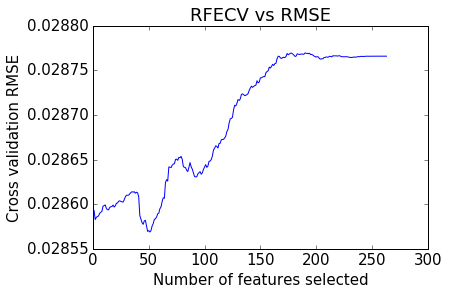

In [23]:
%matplotlib inline 

font = {'family' : 'Bitstream Vera Sans',
        'size'   : 15}

plt.rc('font', **font)

rfecv = selector

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation RMSE")
plt.title('RFECV vs RMSE')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), np.sqrt(abs(rfecv.grid_scores_)))
plt.show()